# Data Exploration

## Overview

In this section we will perform a first overview on wine dataset.
It's hard to know what to do if you don't know what you're working with, so let's load our dataset and take a peek. We will try to figure out the dataset size, number of features and the column types (features + target).

In [1]:
import numpy as np
import pandas as pd
from time import time

%matplotlib inline

# Read student data
data = pd.read_csv("data.csv", delimiter=";")
print("Data read successfully!")

# Calculate number of wines in dataset
n_wines = data.shape[0]

# Calculate number of features
n_features = data.shape[1] - 1

# Print the results
display(data.head())

print("Total number of wines: {}".format(n_wines))
print("Number of features: {}".format(n_features))


Data read successfully!


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Total number of wines: 6497
Number of features: 12


**Attribute types**:

We have the following column types in the dataset:
  - `type`: Categorical (nominal)
  - `fixed acidity`: Numeric (continuous)
  - `volatile acidity`: Numeric (continuous)
  - `citric acid`: Numeric (continuous)
  - `residual sugar`: Numeric (continuous)
  - `chlorides`: Numeric (continuous)
  - `free sulfur dioxide`: Numeric (continuous)
  - `total sulfur dioxide`: Numeric (continuous)
  - `density`: Numeric (continuous)
  - `pH`: Numeric (continuous)
  - `sulphates`: Numeric (continuous)
  - `alcohol`: Numeric (continuous)
  - `quality`: Numeric (ordinal)



# Preparing data

In this section, we will prepare the data for modeling, training and testing.

## Separete feature and target columns

It is often the case that the data contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

The code cell below will separate the wine data into feature and target columns to see if any features are non-numeric.

In [2]:
# Extract feature columns
feature_cols = list(data.columns[:-1])

# Extract target column 'quality'
target_col = data.columns[-1] 

# Show the list of columns
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = data[feature_cols]
y_all = data[target_col]

print("\nFeature types:")
print(X_all.dtypes)

print("\nTarget type:")
print(y_all.dtypes)

print("\nClasses from `type` feature:")
print(data['type'].unique())


Target column: quality

Feature types:
type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                  object
dtype: object

Target type:
int64

Classes from `type` feature:
['White' 'Red']


## Preprocess features

As we can see, there two non-numeric features that need to be converted: `type` and `alcohol`.

The `type` feature only has two classes (`['White' 'Red']`), so it can be reasonably converted into 1/0 (binary) values.

The `alcohol` feature is actually a numeric feature, but some rows are wrong non-numeric values, for example `'110.666.666.666.667'`, `'956.666.666.666.667'`, `'923.333.333.333.333'` and so on. Therefore, we will parse the values of this feature into numeric values and replace the wrong values with the mean of all of the values for the feature ([reference](https://machinelearningmastery.com/handle-missing-data-python/)).

The code cell below performs the preprocessing routine discussed in this section.
 


In [3]:

def preprocess_features(X):
    ''' Preprocesses the data and converts non-numeric binary variables into
        binary (0/1) variables.'''

    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If type, replace all 'White'/'Red' values with 1/0
        if col == 'type' and col_data.dtype == object:
            col_data = col_data.replace(['White', 'Red'], [1, 0])
        
        # If alcohol, parse it values to numberic and coerce the convertion errors
        if col == 'alcohol' and col_data.dtype == object:
            col_data = pd.to_numeric(col_data, errors='coerce')

        # Collect the revised columns
        output = output.join(col_data)

    # handle NaN values by inputting the mean
    output.fillna(output.mean(), inplace=True)
    
    return output

X_all = preprocess_features(X_all)

## Outliers and Feature scaling

We've successfully cleaned our data and converted it into a form which is easily consumable by machine learning algorithms. However, at this point we should consider whether or not some method of data normalization / scaling or outlier removal will be beneficial for our algorithm.

Feature normalization / scaling allows for all features to contribute equally (or more aptly, it allows for features to contribute relative to their importance rather than their scale).

Outliers are extreme values that deviate from other observations on data , they may indicate a variability in a measurement, experimental errors or a novelty. In other words, an outlier is an observation that diverges from an overall pattern on a sample. Some machine learning are sensitive to outliers.

The code cell below plots the boxplot for all features in dataset.

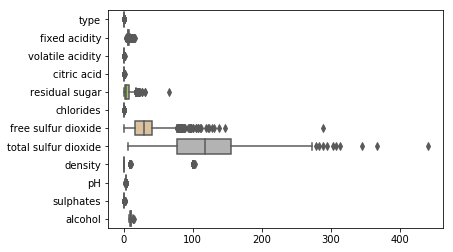

In [4]:
import seaborn as sns
sns.boxplot(data=X_all, orient="h", palette="Set2")

As we can see, the features contain many (extreme) outliers. The code cell bellow performs the outliers removal based on boxplot method and IQR factor (default == 1.5) ([reference](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)). In a later section, we will vary this factor to analyse the best threshold to remove the outliers.

In [5]:
def remove_outliers(X, y, factor=1.5):
    X = X.copy()
    y = y.copy()
    features = X.columns
    data = X.join(y)
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1    
    is_outlier = (X < (Q1 - factor * IQR)) |(X > (Q3 + factor * IQR))
    data = data[~(is_outlier).any(axis=1)]
    return data[features], data[data.columns[-1]]

X_all_noout, y_all_noout = remove_outliers(X_all, y_all)
print("Number of outliers for IQR factor {}: {}".format(1.5, X_all.shape[0] - X_all_noout.shape[0]))
X_all_noout, y_all_noout = remove_outliers(X_all, y_all, factor=3.5)
print("Number of outliers for IQR factor {}: {}".format(3.5, X_all.shape[0] - X_all_noout.shape[0]))


Number of outliers for IQR factor 1.5: 2192
Number of outliers for IQR factor 3.5: 1737


In the boxplot, the range of values varies widely between the features. Therefore, we will create a function to normalize features using min-max or standard methods so that each feature contributes proportionately in the same scale in the models.

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(X, scaler_type='minmax'):
    X = X.copy()
    scaler = MinMaxScaler()
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()

    features = list(X.select_dtypes(include=['float64']).columns)
    X[features] = scaler.fit_transform(X[features])
    return X

# print("Data normalized using min-max method:")
# display(scale(X_all).head())
# print("Data normalized using standard method:")
# display(scale(X_all, scaler_type='standard').head())

## Data balancing

A very frequent problem in machine learning models is imbalanced dataset, because an imbalanced dataset may lead to inflated performance estimates ([reference](https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data)). Therefore, We will analyse if the dataset response variable is balalanced or not.

Plot for the counts of observations in each quality using bars.


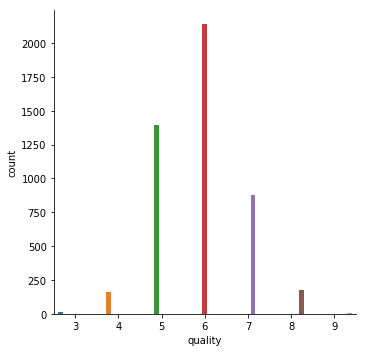

In [7]:
print("Plot for the counts of observations in each quality using bars.")
#sns.catplot("quality", data=data, hue='quality', kind="count")
sns.catplot("quality", data=X_all_noout.join(y_all_noout), hue='quality', kind="count")

As we can see, the response variable `quality` is unbalanced and probably we'll have to handle it later.

## Model Performance Metrics
With the predefined functions above, we will now import the three supervised learning models of our choice and run the train_predict function for each one. We will train and predict on each classifier for four different training set sizes: 25%, 50%, 75% and 100%. Hence, we should expect to have 12 different outputs below — 4 for each model using the varying training set sizes.

In [ ]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the models
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = KNeighborsClassifier(n_neighbors=1)
clf_C = RandomForestClassifier(n_estimators=100)
clf_D = BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
clf_E = LinearDiscriminantAnalysis()
clf_F = LinearSVC(random_state=0)
clf_G = LogisticRegressionCV(random_state=0, multi_class='multinomial')
clf_H = SVC(gamma='auto')
clf_I = MLPClassifier()
clf_J = GradientBoostingClassifier()


def cross_validation(classifier, X, y, cv=3, size_proportions=[0.25, 0.50, 0.75, 1.0]):
    '''
    Execute the 'cross_val_score' function for a classifier, each 
    training set size (25%, 50%, 75%, 100%), and each normalization type (min-max, standard)
    '''
    scores = []
    total_size = X.shape[0]
    sizes = map(lambda p: int(total_size * p), size_proportions)
    X_minmax = scale(X, scaler_type='minmax')
    X_standard = scale(X, scaler_type='standard')

    for size in sizes:
        scores1 = cross_val_score(classifier, X[:size], y[:size], cv=cv)
        scores2 = cross_val_score(classifier, X_minmax[:size], y[:size], cv=cv)        
        scores3 = cross_val_score(classifier, X_standard[:size], y[:size], cv=cv)
        scores.append([size, np.mean(scores1), np.mean(scores2), np.mean(scores3)])
    result = pd.DataFrame(scores, columns=['n', 'X', 'minmax(X)', 'standard(X)'])
    return result

# Execute the 'cross_validation' function for each classifier and each iqr_factor to remove outliers
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G, clf_H, clf_I, clf_J]:
    print("\n[{}]\n".format(clf.__class__.__name__))

    print('Scores with outliers')
    scores = cross_validation(clf, X_all, y_all)
    display(scores)

    for iqr_factor in [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
        print('Scores without outliers, IQR factor', iqr_factor)
        X_nout, y_nout = remove_outliers(X_all, y_all, factor=iqr_factor)
        scores = cross_validation(clf, X_nout, y_nout)
        display(scores)
